In [135]:
import numpy as np
import math
import sympy as sym
from scipy.integrate import ode
from scipy.io import loadmat
import scipy.io
import scipy
from scipy import stats
import pickle
import copy
import filter_functions
from sympy.utilities.lambdify import lambdify
import matplotlib.pyplot as plt
from IPython.core.debugger import Tracer
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 6.0)
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
np.set_printoptions(precision=15)
sym.init_printing()
from IPython.display import display

#MSIS: https://github.com/DeepHorizons/Python-NRLMSISE-00
#import time
from nrlmsise_00_header import *
from nrlmsise_00 import *
#SUBROUTINE GTD7D -- d[5] is the "effective total mass density
#for drag" and is the sum of the mass densities of all species
#in this model, INCLUDING anomalous oxygen.

#define constants
r_earth_const = 6378136.3 * 1e-3 #km
omega_const = 7.2921158553e-5 #rad/s, angular velocity of earth
J_2_const = .00108262617385222
J_3_const = -.00000253241051856772
mu_earth = 3.986004415e14 * 1e-9 #km^3/s^2


#Drag:
A_const = 0.9551567 * 1e-6 #km^2; cross-sectional area of satellite
m_const = 10 #kg; mass of satellite
C_D_const = 2.0
theta_dot_const = 7.2921158553e-5 #rad/sec

In [136]:

num_of_X_ensembles = 450

meas_type = 3

if meas_type == 1:
    meas_file = open('Data Files/meas_range_rangeRate.pkl', 'rb')
elif meas_type == 2:
    meas_file = open('Data Files/meas_az_el.pkl', 'rb')
elif meas_type == 3:
    meas_file = open('Data Files/meas_az_el_range_90RAAN.pkl', 'rb') #_10s_all_3stat.pkl
    
    
    
#Date of Simulation Details:
#June 24th, 2017 at 6am (this is the date & time at the beginning of the simulation/orbit)
year_init = 2017
month_init = 6
day_of_month_init = 24
day_of_year_init = 175
hour_init = 6
boulder_UT_offset = 6 #Boulder time + 6 hours = UT time
hour_init_UT = hour_init + boulder_UT_offset
    
    

#Canbera Station (DSS 34)
lat_dss34 = math.radians(-35.398333)
lon_dss34 = math.radians(148.981944)
alt_dss34 = 691.75 * 1e-3 #km

r_ecef_dss34 = filter_functions.topo2ecef(lat_dss34, lon_dss34, alt_dss34, r_earth_const)
#print(r_ecef_dss34)

#Madrid Station (DSS 65) -- correct position of Madrid Station
lat_dss65 = math.radians(40.427222)
lon_dss65 = math.radians(355.749444)
alt_dss65 = 834.539 * 1e-3 #km

r_ecef_dss65 = filter_functions.topo2ecef(lat_dss65, lon_dss65, alt_dss65, r_earth_const)
#print(r_ecef_dss65)

#Goldstone Station (DSS 13) 
lat_dss13 = math.radians(35.247164)
lon_dss13 = math.radians(200.205)
alt_dss13 = 1071.14904 * 1e-3 #km

r_ecef_dss13 = filter_functions.topo2ecef(lat_dss13, lon_dss13, alt_dss13, r_earth_const)
#print(r_ecef_dss13)

#Diego Garcia, British Indian Ocean Territory 7.41173°S 72.45222°E., Space Fence (Dedicated Sensor
lat_diego = math.radians(-7.41173)
lon_diego = math.radians(72.45222)
alt_diego = 0 * 1e-3 #km, "sea level"

r_ecef_diego = filter_functions.topo2ecef(lat_diego, lon_diego, alt_diego, r_earth_const)




# read python dict containing measurements
mydict2 = pickle.load(meas_file)
meas_file.close()
measurement_array = mydict2['measurement_array']
truth_xyz = mydict2['truth_pos_vel']
true_density_array = mydict2['true_density']
lat_lst_meas_array = mydict2['lat_lst_array']
print(np.shape(measurement_array))
print(np.shape(truth_xyz))

#convert to km
truth_xyz = truth_xyz * 1e-3
measurement_array[:, -1] = measurement_array[:, -1] * 1e-3
print(measurement_array[200,0]/(60))
print(measurement_array[150,0]/(60)/90)





(407, 5)
(407, 6)
784.0
7.9


In [137]:
#read in files necessary for ensemble & density est. portion


# read python dict containing densities
ensemble_file = open('Data Files/ensemble_density_grids.pkl', 'rb')
mydict2 = pickle.load(ensemble_file)
ensemble_file.close()

#shape: ensembles (# of combos) by lat by lon
ensembles_of_density_grid = mydict2['ensemble_of_density_grids'] 
print('Shape of Vector of State/density Ensembles:', np.shape(ensembles_of_density_grid))
(num_of_ensembles, num_of_lat, num_of_lon) = np.shape(ensembles_of_density_grid)

#convert from kg/m**3 to kg/km**3 -> 1/(1e-3)**3 = 1/(1e-9) = 1e9
ensembles_of_density_grid = ensembles_of_density_grid * 1e9

latitude_grid = mydict2['latitudes'] 
longitude_grid = mydict2['longitudes'] 
lat_res = latitude_grid[1] - latitude_grid[0] #spacing between each latitude "tick"
lon_res = longitude_grid[1] - longitude_grid[0] #spacing between each longitude "tick"



#add noise w/ standard deviation = 1e-4 (used as initialization of density covariance, as well)

print(np.sum(ensembles_of_density_grid[:, 0, 0])/num_of_ensembles)
ensemble_noise = np.random.randn(num_of_ensembles, num_of_lat, num_of_lon) * 1e-4#1e-9 #1e-4****
ensembles_of_density_grid = ensembles_of_density_grid + ensemble_noise
print(np.sum(ensembles_of_density_grid[:, 0, 0])/num_of_ensembles) 


Shape of Vector of State/density Ensembles: (450, 37, 73)
0.000479211906198
0.00047929873923


In [138]:

#Propogate reference trajectory and S.T.M.
def orbitpropogator_EnKF(t, X_vector, density):
    
    ensemble_member = X_vector

    #find X acceleration via the F(X) lambdified equation
    state_acc = X_dot_sol_fcn(ensemble_member[0], ensemble_member[1], ensemble_member[2], \
                                  ensemble_member[3], ensemble_member[4], ensemble_member[5], density)
        
    dx = state_acc.flatten()
    return dx



#Propogate reference trajectory and S.T.M.
def orbitpropogator(t, X_vector, density):
    state = X_vector[0:3] 
    state_v = X_vector[3:6]

    
    #find X acceleration via the F(X) lambdified equation
    state_acc = X_dot_sol_fcn(*state, *state_v, density)


    #stm propogation: stm_dot = A*stm
    stm = X_vector[6:]
    stm = stm.reshape(6, 6)
    A = A_sol_fcn(state[0], state[1], state[2], state_v[0], state_v[1], state_v[2], density)

    stm_dot = np.dot(A, stm)

    dx = np.append(np.array(state_acc), stm_dot.flatten())
    return dx

In [139]:
#two body motion force
# **Setup force equations/acceleration/U

#Force equations with J_2
x, y, z, J_2, r_earth, mu, r, J_3 = sym.symbols('x y z J_2 r_earth mu r J_3')


two_body_J2_string = 'mu/r * ( 1 - J_2*(r_earth/r)**2 * (3/2 * (z/r)**2 - 1/2) )' #potential
two_body_J2 = sym.sympify(two_body_J2_string)
two_body_J2 = two_body_J2.subs([(r, sym.sqrt(x**2+y**2+z**2))])
two_body_J2_acc_x = two_body_J2.diff(x)
two_body_J2_acc_y = two_body_J2.diff(y)
two_body_J2_acc_z = two_body_J2.diff(z)


two_body_J2_acc_x = two_body_J2_acc_x.subs([(r_earth, r_earth_const), (mu, mu_earth), \
                              (J_2, J_2_const)])
two_body_J2_acc_y = two_body_J2_acc_y.subs([(r_earth, r_earth_const), (mu, mu_earth), \
                              (J_2, J_2_const)])
two_body_J2_acc_z = two_body_J2_acc_z.subs([(r_earth, r_earth_const), (mu, mu_earth), \
                              (J_2, J_2_const)])
#print('2 body & J2', two_body_J2_acc_x)

x_acc = two_body_J2_acc_x
y_acc = two_body_J2_acc_y
z_acc = two_body_J2_acc_z

In [140]:
#Add drag to J_2 force equations

x_dot, y_dot, z_dot, x_double_dot, y_double_dot, z_double_dot = \
    sym.symbols('x_dot, y_dot, z_dot, x_double_dot, y_double_dot, z_double_dot')
    
C_D, A, m, density, theta_dot, val, val_dot = \
    sym.symbols('C_D A m density theta_dot val, val_dot')

drag_str = ('-(1/2)*C_D*(A/m)*density*'
                'sqrt((x_dot+theta_dot*y)**2 + (y_dot-theta_dot*x)**2 +'
                'z_dot**2)*(val_dot+theta_dot*val)')
drag_symp = sym.sympify(drag_str)

drag_symp = drag_symp.subs([(A, A_const), (m, m_const), (C_D, C_D_const),\
                        (theta_dot, theta_dot_const)])


x_drag_symp = drag_symp.subs([(r, sym.sqrt(x**2+y**2+z**2)), (val, y), (val_dot, x_dot)])
x_acc = x_acc + x_drag_symp

y_drag_symp = drag_symp.subs([(r, sym.sqrt(x**2+y**2+z**2)), (val, x), (val_dot, y_dot)])
y_acc = y_acc + y_drag_symp

z_drag_symp = drag_symp.subs([(r, sym.sqrt(x**2+y**2+z**2)), (val, z), (val_dot, z_dot)])
z_acc = z_acc + z_drag_symp
    


x_acc_sol_fcn = lambdify((x, y, z, x_dot, y_dot, z_dot, density), x_acc)
y_acc_sol_fcn = lambdify((x, y, z, x_dot, y_dot, z_dot, density), y_acc)
z_acc_sol_fcn = lambdify((x, y, z, x_dot, y_dot, z_dot, density), z_acc)

In [141]:


if (meas_type == 1) or (meas_type == 3):
    
    x_s, y_s, z_s, x_sf, y_sf, z_sf, theta, theta_dot, t, x_dot, y_dot, z_dot = \
        sym.symbols('x_s, y_s, z_s, x_sf, y_sf, z_sf, theta, theta_dot, t, x_dot, y_dot, z_dot')

    #define symbolic rho equation
    rho = ('sqrt((x - x_s)**2 + (y - y_s)**2 + (z - z_s)**2)')
    rho = sym.sympify(rho)
    #sub rotation equation of ecef for eci
    rho = rho.subs(x_s, x_sf*sym.cos(omega_const*t) - y_sf*sym.sin(omega_const*t))
    rho = rho.subs(y_s, x_sf*sym.sin(omega_const*t) + y_sf*sym.cos(omega_const*t))
    rho = rho.subs(z_s, z_sf)

    #define symbolic rho dot equation
    rho_dot = ('(x*x_dot + y*y_dot + z*z_dot - (x_dot*x_s+y_dot*y_s)*cos(theta) + \
               theta_dot*(x*x_s + y*y_s)*sin(theta) + (x_dot*y_s - y_dot*x_s)*sin(theta) +\
               theta_dot*(x*y_s - y*x_s)*cos(theta) - z_dot*z_s)/ rho')
    rho_dot = sym.sympify(rho_dot)
    #execute substitutions for rho_dot
    rho_dot = rho_dot.subs(x_s, x_sf) 
    rho_dot = rho_dot.subs(y_s, y_sf) 
    rho_dot = rho_dot.subs(z_s, z_sf) 
    rho_dot = rho_dot.subs('rho', rho)
    rho_dot = rho_dot.subs(theta, omega_const*t)    
    rho_dot = rho_dot.subs(theta_dot, omega_const)

    rho_fcn = lambdify(((x, y, z, x_sf, y_sf, z_sf, t)), rho)
    rho_dot_fcn = lambdify(((x, y, z, x_dot, y_dot, z_dot, x_sf, y_sf, z_sf, t)), rho_dot)


if (meas_type == 2) or (meas_type == 3):
    
    #x_sf, etc. is the sensor pos in ecef
    #x, y, z is the satellite eci
    x_s, y_s, z_s, x_sf, y_sf, z_sf, theta, x, y, z, t = \
        sym.symbols('x_s, y_s, z_s, x_sf, y_sf, z_sf, theta, x, y, z, t')
    x_L, y_L, z_L, X_L_norm, x_range, y_range, z_range, lon, lat, \
        x_sat_ecef, y_sat_ecef, z_sat_ecef, sen_ecef_norm, omega  = \
        sym.symbols('x_L, y_L, z_L, X_L_norm, x_range, y_range, z_range, lon, lat, \
        x_sat_ecef, y_sat_ecef, z_sat_ecef, sen_ecef_norm, omega')
        

    #define symbolic rho equation
    azimuth = ('atan2(x_L, y_L)') #step 4
    azimuth = sym.sympify(azimuth)
    
    elevation = ('asin(z_L/X_L_norm)') #step 4
    elevation = sym.sympify(elevation)
    elevation = elevation.subs(X_L_norm, sym.sqrt(x_L**2 + y_L**2 + z_L**2))
    
    #step 3
    azimuth = azimuth.subs([(x_L, -x_range*sym.sin(lon) + y_range*sym.cos(lon)), \
            (y_L, -x_range*sym.sin(lat)*sym.cos(lon) - y_range*sym.sin(lat)*sym.sin(lon) + z_range*sym.cos(lat))])
    elevation = elevation.subs([(x_L, -x_range*sym.sin(lon) + y_range*sym.cos(lon)), \
            (y_L, -x_range*sym.sin(lat)*sym.cos(lon) - y_range*sym.sin(lat)*sym.sin(lon) + z_range*sym.cos(lat)), \
            (z_L, x_range*sym.cos(lat)*sym.cos(lon) + y_range*sym.cos(lat)*sym.sin(lon) + z_range*sym.sin(lat))])
    
    #step 2
    azimuth = azimuth.subs([(x_range, x_sat_ecef - x_sf), (y_range, y_sat_ecef - y_sf), \
            (z_range, z_sat_ecef - z_sf), (lat, sym.asin(z_sf/sen_ecef_norm)), (lon, sym.atan2(y_sf, x_sf))])
    elevation = elevation.subs([(x_range, x_sat_ecef - x_sf), (y_range, y_sat_ecef - y_sf), \
            (z_range, z_sat_ecef - z_sf), (lat, sym.asin(z_sf/sen_ecef_norm)), (lon, sym.atan2(y_sf, x_sf))])
    
    #step 1
    azimuth = azimuth.subs([(x_sat_ecef, x*sym.cos(theta) + y*sym.sin(theta)), \
                        (y_sat_ecef, -x*sym.sin(theta) + y*sym.cos(theta)), (z_sat_ecef, z), \
                        (sen_ecef_norm, sym.sqrt(x_sf**2 + y_sf**2 + z_sf**2))])
    elevation = elevation.subs([(x_sat_ecef, x*sym.cos(theta) + y*sym.sin(theta)), \
                        (y_sat_ecef, -x*sym.sin(theta) + y*sym.cos(theta)), (z_sat_ecef, z), \
                        (sen_ecef_norm, sym.sqrt(x_sf**2 + y_sf**2 + z_sf**2))])
    
    
    azimuth = azimuth.subs([(theta, omega_const*t), (omega, omega_const)])
    elevation = elevation.subs([(theta, omega_const*t), (omega, omega_const)])
    
    azimuth_fcn = lambdify(((x, y, z, x_sf, y_sf, z_sf, t)), azimuth)
    elevation_fcn = lambdify(((x, y, z, x_sf, y_sf, z_sf, t)), elevation)
    



In [142]:
#State and A matrix


#define the symbolic state matrix
X = sym.Matrix([x, y, z, x_dot, y_dot, z_dot])
X_dot = sym.Matrix([x_dot, y_dot, z_dot, x_acc, y_acc, z_acc])
    

#partial of the force model (x dot) WRT the state vector
A_mat = X_dot.jacobian(X)
#print(A_mat)

A_sol_fcn = lambdify((x, y, z, x_dot, y_dot, z_dot, density), A_mat)
#print(A_sol_fcn(1,2,3,4,5,6,7,8))

#print(X_dot)
X_dot_sol_fcn = lambdify((x, y, z, x_dot, y_dot, z_dot, density), X_dot)

In [143]:
#define observation model (G) and H_tilde


if meas_type == 1:
    G = sym.Matrix([rho, rho_dot])
    
    
elif meas_type == 2:
    G = sym.Matrix([azimuth, elevation])
    
elif meas_type == 3:
    G = sym.Matrix([azimuth, elevation, rho])

#print(G)
G_sol_fcn = lambdify((x, y, z, x_dot, y_dot, z_dot, x_sf, y_sf, z_sf, t), G)

#partial derivitive of observation model WRT the state vector
H_tilde = G.jacobian(X)
#print(H_tilde)
H_tilde_sol_fcn = lambdify((x, y, z, x_dot, y_dot, z_dot, x_sf, y_sf, z_sf, t), H_tilde)

In [144]:
#define reference state at epoch, covariance at epoch, and R (using measurement noise)

prob_dimension = 6

pos_perturbation = 100 * 1e-3 #km
vel_perturbation = .1 * 1e-3 #km/s

X_ref = np.array([truth_xyz[0,0] + pos_perturbation, truth_xyz[0,1] + pos_perturbation, truth_xyz[0,2] \
            + pos_perturbation, truth_xyz[0,3] + vel_perturbation, truth_xyz[0,4] + vel_perturbation, \
            truth_xyz[0,5] + vel_perturbation])


P_sigma_pos = 100 * 1e-3 #km
P_sigma_vel = .1 * 1e-3 #km/s
P_bar_0 = np.diag([P_sigma_pos**2, P_sigma_pos**2, P_sigma_pos**2, \
                   P_sigma_vel**2, P_sigma_vel**2, P_sigma_vel**2]) 

#for process noise
snc_sigma = 1e-5

                  
#Define Measurement Noise
if meas_type == 1:
    sigma_rho = .1 * 1e-3 #km
    sigma_rho_dot = .01 * 1e-3 #km/s
    W = np.array([[1/sigma_rho**2, 0], [0, 1/sigma_rho_dot**2]])
    R = np.linalg.inv(W)
    
elif meas_type == 2:
    arcsec_per_rad = 206264.806247 #arcsec/rad
    noise_rad = (1/arcsec_per_rad)  * 5  #5 arcsec noise (suggested by Moriba for a telescope)
    sigma_az = noise_rad
    sigma_el = noise_rad
    W = np.array([[1/sigma_az**2, 0], [0, 1/sigma_el**2]])
    R = np.linalg.inv(W)
    
elif meas_type == 3:
    arcsec_per_rad = 206264.806247 #arcsec/rad
    noise_rad = (1/arcsec_per_rad)  * 5  #5 arcsec noise (suggested by Moriba for a telescope)
    sigma_az = noise_rad
    sigma_el = noise_rad
    sigma_rho = .1 * 1e-3 #km
    W = np.array([[1/sigma_az**2, 0, 0], [0, 1/sigma_el**2, 0], [0, 0, 1/sigma_rho**2]])
    R = np.linalg.inv(W)
    
    meas_indices = np.array([0, 1, 2])

    

    
print(X_ref)

[  7.950796762291823e+02   6.701934506850498e+03  -6.279746517887071e+02
  -5.805111155451634e+00   1.147516427146103e+00   4.877657130745605e+00]


In [145]:
#KALMAN : Extended*****

def execute_ekf(obs_data, X_ref, P_bar_0, prob_dimension, stop_index, snc_flag):

    #initializations
    stm_tfinal_t0 = np.identity(prob_dimension)
    stm_0_to_final = np.eye(prob_dimension)
    stm_0 = np.identity(prob_dimension)
    
    num_of_meas = np.shape(R)[0]

    P = P_bar_0
    x_bar_0 = np.zeros((prob_dimension, 1))
    x_hat = x_bar_0 


    stm_kalman_list = np.array([])
    P_position_trace = np.array([])
    P_velocity_trace = np.array([])

    pre_fit_list = np.array([])
    predicted_list = np.array([])
    post_fit_list = np.array([])

    P_list = np.array([])
    x_ref_updated_list = np.array([])


    n = len(obs_data)
    ekf_flag = 0

    for obsnum in range(stop_index):
        
        time = obs_data[obsnum, 0]
        t_init = obs_data[obsnum-1, 0]
        if obsnum == 0:
            t_init = obs_data[obsnum, 0]
        
        print(obsnum, obs_data[obsnum, 0])

        #set the initial values for the propogator:
        X_ref = np.array(X_ref)
        y0 = np.append(X_ref.flatten(), stm_0[:].flatten()) 

        result = y0

        if (obs_data[obsnum, 0] != obs_data[obsnum-1, 0]) and (obsnum != 0):
            integrator = ode(orbitpropogator)
            density = true_density_array[obsnum]
            integrator.set_integrator('dopri5', nsteps=1e6, rtol=1e-12, atol=1e-12)
            integrator.set_f_params(density)

            integrator.set_initial_value(y0, t_init)
            integrator.integrate(time)
            result = integrator.y
            

        result = np.array(result)
        X_ref = result[0:prob_dimension]
        X = result[0:3]
        V = result[3:6]
        stm_kalman = result[prob_dimension:].reshape(prob_dimension, prob_dimension)

        stm_0_to_final = np.dot(stm_kalman, stm_0_to_final)


        #Time Update- only if measurement is at different time than last measurement
        if (obs_data[obsnum, 0] != obs_data[obsnum-1, 0])  and (obsnum != 0): #or (obsnum == 0):
            x_bar = np.dot(stm_kalman, x_hat)
            P_bar = np.dot(stm_kalman, np.dot(P, stm_kalman.T))
            
            #Use SNC P_bar if delta t is less than 100 seconds---------------------------
            delta_t = obs_data[obsnum, 0] - obs_data[obsnum-1, 0]
            if obsnum == 0:
                delta_t = 0
            if (delta_t < 15 and snc_flag):
                #build SNC STM
                idenity_6_3 = np.array([(delta_t/2)*np.eye(3), np.eye(3)]).reshape(6, 3)
                snc_stm = delta_t*idenity_6_3
                #Covariance with SNC: Q Matrix
                Q = np.identity(3)*(snc_sigma)**2
                P_bar = np.dot(snc_stm, np.dot(Q, snc_stm.T)) + P_bar
        else:
            x_bar = x_hat
            P_bar = P

            
        #determine station coordinates for observation eq.
        if int(obs_data[obsnum, 1]) == 1:
            #print('1')
            X_s = r_ecef_dss34
        if int(obs_data[obsnum, 1]) == 2:
            #print('2')
            X_s = r_ecef_dss65
        if int(obs_data[obsnum, 1]) == 3:
            #print('3')
            X_s = r_ecef_dss13
        if int(obs_data[obsnum, 1]) == 4:
            #print('amos')
            X_s = r_ecef_diego
            


        #fill H_tilde for everything but sensors
        H_tilda_result = H_tilde_sol_fcn(*X, *V, *X_s, time)
        
        val = np.dot(H_tilda_result, np.dot(P_bar, H_tilda_result.T))
        val2 = np.linalg.inv(np.add(val, R))
        K = np.dot(P_bar, np.dot(H_tilda_result.T, val2))

        #y calculation
        #determine observation as evaluated in observation equation with ref. 
        y_G_ref = G_sol_fcn(*X, *V, *X_s, time)
        if (meas_type != 1) and (y_G_ref[0] < 0): #if az less than 0, add 2*pi
                y_G_ref[0] = y_G_ref[0] + 2*math.pi

        #get actual observation
        y_observed = obs_data[obsnum, 2:(2+num_of_meas)].reshape(num_of_meas,1)

        #calculate y
        y = y_observed - y_G_ref

        x_hat = x_bar + np.dot(K, (y - np.dot(H_tilda_result, x_bar)))
        x_hat_result = x_hat
        
        #save values
        x_ref_updated = x_hat[0:6].flatten() + np.array([X, V]).flatten()
        x_ref_updated_list = np.append(x_ref_updated_list, x_ref_updated)

        part1 = (np.identity(prob_dimension) - np.dot(K, H_tilda_result))
        P = np.dot(part1, np.dot(P_bar, part1.T)) + np.dot(K, np.dot(R, K.T))
        P_position_trace = np.append(P_position_trace, np.trace(P[0:3, 0:3]))
        P_velocity_trace = np.append(P_velocity_trace, np.trace(P[3:6, 3:6]))
        P_list = np.append(P_list, P)


        #RMS / Residuals----------------------------------------------------------
        pre_fit_resid = y
        pre_fit_list = np.append(pre_fit_list, pre_fit_resid)   

        predicted_resid = y - np.dot(H_tilda_result, x_bar)
        predicted_list = np.append(predicted_list, predicted_resid)   

        post_fit_resid = y - np.dot(H_tilda_result, x_hat)
        post_fit_list = np.append(post_fit_list, post_fit_resid)  


        #Determine whether to switch to EKF
        if(obsnum >= 70):
            
            X_ref = x_hat.reshape(prob_dimension,1) + X_ref.reshape(prob_dimension,1)
            x_hat = np.zeros((prob_dimension,1))
            
            


    #resize arrays
    P_list.shape = (stop_index, 6, 6)
    x_ref_updated_list.shape = (stop_index, 6)
    pre_fit_list.shape = (stop_index, num_of_meas)
    predicted_list.shape = (stop_index, num_of_meas)
    post_fit_list.shape = (stop_index, num_of_meas)
    
    return (x_ref_updated_list, P_list, pre_fit_list, predicted_list, post_fit_list)

In [146]:
#Call EnKF

"""
stop_index = 35 #558 * 3 #92.56 minutes #/2

(X_mean_updated_list_EnKF, P_list_EnKF, post_fit_list_EnKF, density_MSIS_array, est_density_array,\
X_distribution, density_distribution, lat_lst_array, updated_density_portion, X_ensemble, est_density_grid_array) = \
            execute_enkf(measurement_array, X_ensemble, P_bar_0, R, ensembles_of_density_grid,\
                         prob_dimension, density_dimension, stop_index)
"""

snc_flag = True
stop_index = len(measurement_array)   

(x_ref_updated_list_EKF, P_list_EKF, pre_fit_list_EKF, predicted_list_EKF, post_fit_list_EKF) = \
                        execute_ekf(measurement_array, X_ref, P_bar_0, prob_dimension, stop_index, snc_flag)
    


0 5410.0
1 5420.0
2 5430.0
3 5440.0
4 5450.0
5 5460.0
6 5470.0
7 5480.0
8 5490.0
9 5500.0
10 5510.0
11 5520.0
12 5530.0
13 5540.0
14 5550.0
15 5560.0
16 5570.0
17 5580.0
18 5590.0
19 5600.0
20 5610.0
21 5620.0
22 5630.0
23 5640.0
24 34020.0
25 34030.0
26 34040.0
27 34050.0
28 34060.0
29 34070.0
30 34080.0
31 34090.0
32 34100.0
33 34110.0
34 34120.0
35 34130.0
36 34140.0
37 34150.0
38 34160.0
39 34170.0
40 34180.0
41 34190.0
42 34200.0
43 34210.0
44 34220.0
45 34230.0
46 34240.0
47 34250.0
48 34260.0
49 34270.0
50 34280.0
51 34290.0
52 34300.0
53 34310.0
54 34320.0
55 36600.0
56 36610.0
57 36620.0
58 36630.0
59 36640.0
60 36650.0
61 36660.0
62 36670.0
63 36680.0
64 36690.0
65 36700.0
66 36710.0
67 36720.0
68 36730.0
69 36740.0
70 36750.0
71 36760.0
72 36770.0
73 36780.0
74 36790.0
75 36800.0
76 36810.0
77 36820.0
78 36830.0
79 36840.0
80 36850.0
81 36860.0
82 39800.0
83 39810.0
84 39820.0
85 39830.0
86 39840.0
87 39850.0
88 39860.0
89 39870.0
90 39880.0
91 39890.0
92 39900.0
93 39910.0


Post-fit RMS:
Azimuth = 0.00913571450687 degrees
Elevation = 0.00282420308906 degrees
Range = 0.000276272140363 km


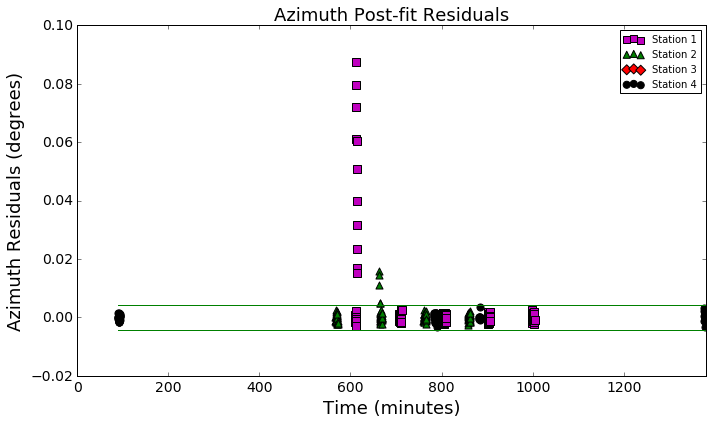

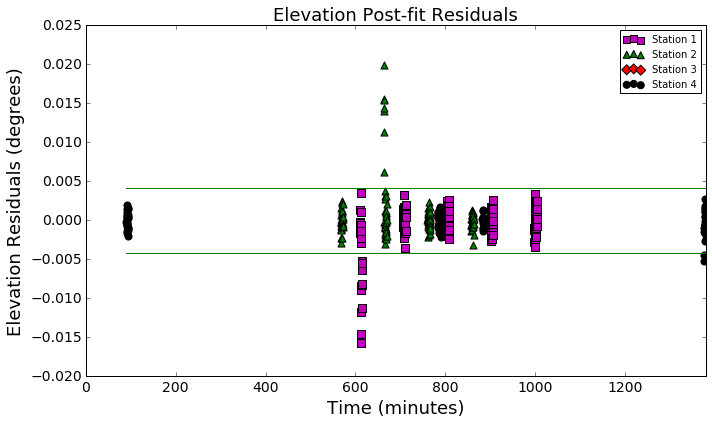

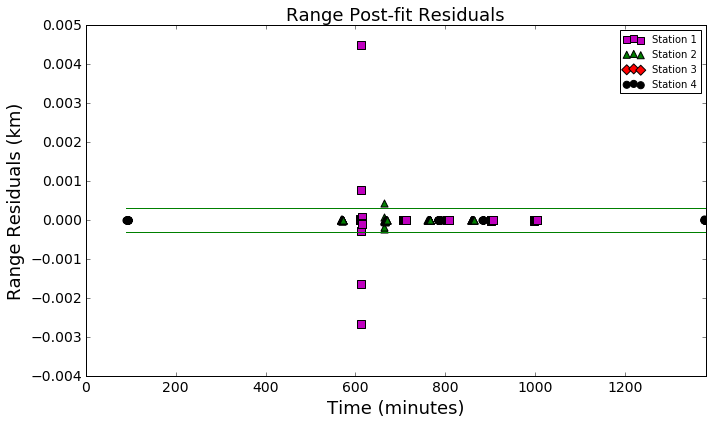

Position RMS:
X = 0.0638128851551 km
Y = 0.138277554372 km
Z = 0.107716498683 km
Overall = 0.186535815444 km


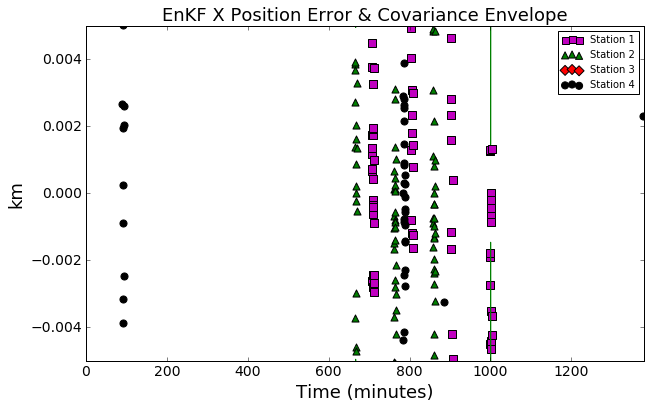

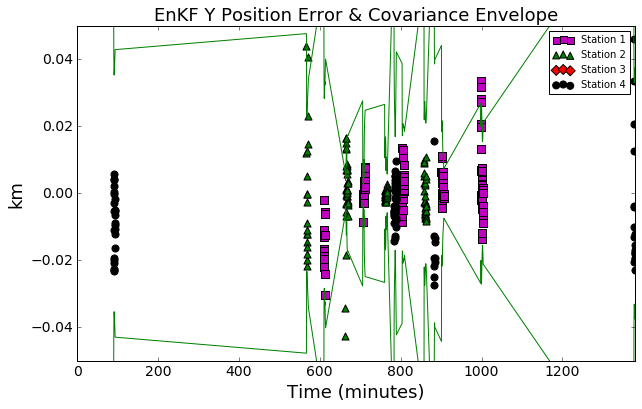

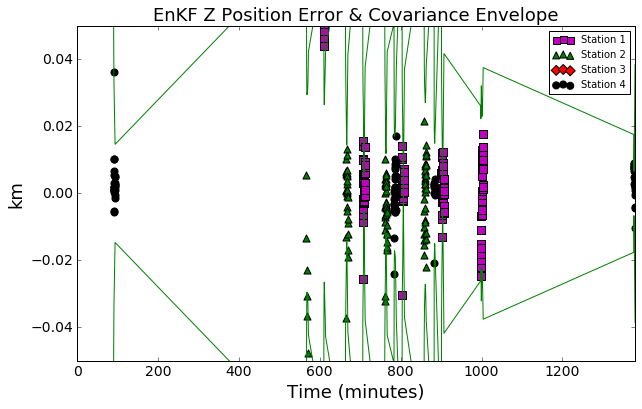

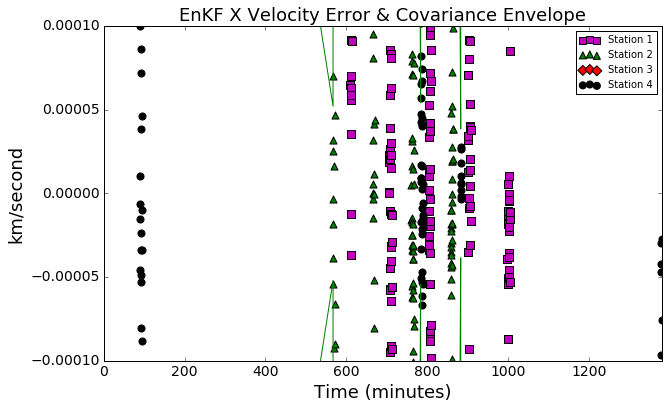

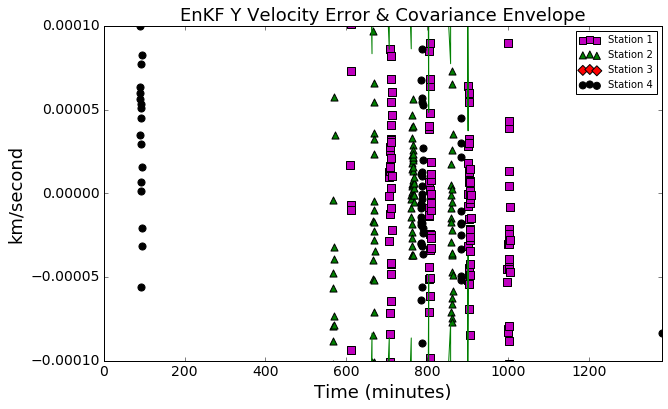

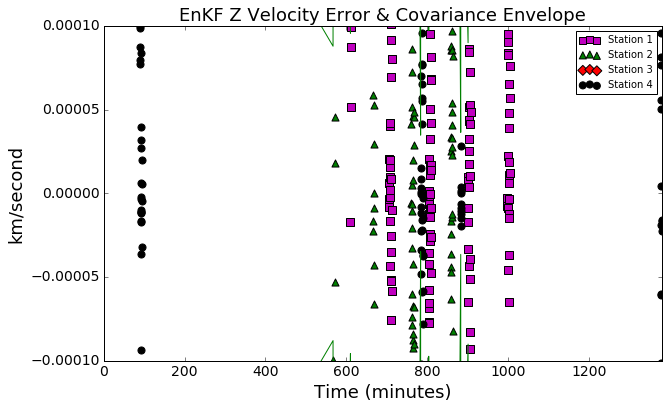

Velocity RMS:
X = 0.00146665662126 km/second
Y = 0.00115103356957 km/second
Z = 0.000901370841138 km/second
Overall = 0.00207085231637 km/s


In [147]:

#Generate Plots for Analysis

x_range = .005
y_range = .05
z_range = .05

xv_range = 1e-4
yv_range = 1e-4
zv_range = 1e-4

times = measurement_array[:, 0]
time_str = 'Time (minutes)'

saveFig_bool = True

x_ref_updated_list_EKF, P_list_EKF, pre_fit_list_EKF, predicted_list_EKF, post_fit_list_EKF


filter_functions.calc_display_results(post_fit_list_EKF, measurement_array, R, meas_type, stop_index, saveFig_bool,\
                                     time_str)


filter_functions.plot_error_covar_xref_noDensity(P_list_EKF, x_ref_updated_list_EKF, \
                      truth_xyz, x_range, y_range, z_range, xv_range, yv_range, zv_range,\
                      measurement_array, times, stop_index, saveFig_bool, time_str)


In [148]:
indices = np.where(measurement_array[:, 1] == 1)[0]
print(indices)
indices = np.where(measurement_array[:, 1] == 2)[0]
print(indices)
indices = np.where(measurement_array[:, 1] == 3)[0]
print(indices)
indices = np.where(measurement_array[:, 1] == 4)[0]
print(indices)

[ 55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81 120 121 122 123 124 125 126 127 128
 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146
 147 148 149 150 151 152 153 154 155 156 157 233 234 235 236 237 238 239
 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257
 258 259 260 261 262 263 264 265 266 267 268 313 314 315 316 317 318 319
 320 321 322 323 324 325 326 327 328 329 330 331 332 333 334 335 336 337
 338 339 340 341 342 343 344 345 346 347 348 349 350 351 352 353 354 355
 356 357 358 359 360 361 362 363 364 365 366 367 368 369 370 371 372 373
 374 375 376 377 378 379 380 381 382 383 384 385 386 387]
[ 24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41
  42  43  44  45  46  47  48  49  50  51  52  53  54  82  83  84  85  86
  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104
 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 158 1

In [156]:
delta_t = 10
idenity_6_3 = np.array([(delta_t/2)*np.eye(3), np.eye(3)]).reshape(6, 3)
snc_stm = delta_t*idenity_6_3
print(snc_stm)
#Covariance with SNC: Q Matrix
Q = np.identity(3)*(snc_sigma)**2
print(Q)
np.dot(snc_stm, np.dot(Q, snc_stm.T))
print(np.diag(np.dot(snc_stm, np.dot(Q, snc_stm.T))))

[[ 50.   0.   0.]
 [  0.  50.   0.]
 [  0.   0.  50.]
 [ 10.   0.   0.]
 [  0.  10.   0.]
 [  0.   0.  10.]]
[[  1.000000000000000e-10   0.000000000000000e+00   0.000000000000000e+00]
 [  0.000000000000000e+00   1.000000000000000e-10   0.000000000000000e+00]
 [  0.000000000000000e+00   0.000000000000000e+00   1.000000000000000e-10]]
[  2.500000000000000e-07   2.500000000000000e-07   2.500000000000000e-07
   1.000000000000000e-08   1.000000000000000e-08   1.000000000000000e-08]
